# Salary Analytics

This repository consists of conducting analysis on publicly submitted salaries. The data was gathered and inspired by Christen Nino De Guzman on her LinkedIn post about wage transparency. You can find the post here and the associated CSV file here. She advocated this on her LinkedIn community and it gained a lot of traction, nearly 60,000 people have anonymously submitted their total compensation breakdown, gender, age-range, etc. The focus of this article is to conduct an analysis of the data retrieved. The article will consist of a few different segments as outlined below:  

**Table of Contents**
- Data Retrieval
- Data Cleaning
- Analysis & Visualization
- Caveats of Analysis
- Concluding Remarks
- Resources

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
# constants
# source = https://docs.google.com/spreadsheets/d/19h0WT9Xjf9ncNmJDWpd8fzz7YnB37nemDnxKSO0EE8o/edit#gid=1664289965
file_path = './data/anon_salary.csv'

## Import Data

In [3]:
d = pd.read_csv(file_path)
d.shape

(59688, 22)

In [4]:
d.columns

Index(['Timestamp', 'Age Range', 'Years of Experience', 'Industry',
       'Job Title', 'Company Name', 'Highest Level of Education Received',
       'Closest Major City and State (e.g. Santa Clara, CA)', 'Country',
       'Annual Base Salary (if hourly, please convert to annual)',
       'Annual Bonus', 'Annual Average of RSUs',
       'Signing Bonus (if none, leave blank)', 'Currency (USD, CAD, etc)',
       'How many vacation days are you given per year?',
       'How many sick days are you given per year?',
       'How many days per week are you required to work onsite/in the office?',
       'Do you openly discuss salary with your colleagues?',
       'How many months Maternity or Paternity does your company offer?',
       'Gender (optional)', 'Unnamed: 20', 'Diverse Identity (Optional)'],
      dtype='object')

## Clean Data

During the cleaning components, we're not going to really aim for perfection as there's just too much data to parse through manually and too many individual edge cases which would act as outliers. We're aiming to clean the masses of the results that users have submitted. So the cleaning portion will most definetly not be perfect, but when dealing with a large volume of user submitted data without any options / restrictions in place for the submissions, it becomes almost impossible to have **perfectly** cleaned data. In this section we'll begin by renaming the columns to remove any fluf and wierd wording in them.

In [5]:
rename_cols = {
    'Timestamp' : 'timestamp',
    'Country' : 'country',
    'Age Range' : 'age_range',
    'Highest Level of Education Received' : 'max_edu',
    'Company Name' : 'org',
    'Years of Experience' : 'yoe',
    'Closest Major City and State (e.g. Santa Clara, CA)' : 'loc_city',
    'Annual Base Salary (if hourly, please convert to annual)' : 'annual_wage',
    'How many vacation days are you given per year?' : 'vacation_days_yearly',
    'How many sick days are you given per year?' : 'sick_days_yearly',
    'Do you openly discuss salary with your colleagues?' : 'open_wage_discussions',
    'How many months Maternity or Paternity does your company offer?' : 'maternity_leave_months',
    'Diverse Identity (Optional)' : 'ethnicity',
    'Currency (USD, CAD, etc)' : 'currency',
    'Gender (optional)' : 'gender',
    'Annual Bonus' : 'bonus',
    'Annual Average of RSUs' : 'avg_rsu',
    'Signing Bonus (if none, leave blank)' : 'signing_bonus',
    'Job Title' : 'job_title',
    'How many days per week are you required to work onsite/in the office?' : 'days_per_week_in_office'
}

d.rename(columns = rename_cols, inplace = True)
d.drop(columns = ['Unnamed: 20'], inplace = True)

In [6]:
curr_dct = {
    # I'm aware that dollars and $ can be across many different currencies, I'm making a generalized assumption
    'usd' : ['us dollar', 'us dollars', 'usda', 'usdp', 'dollars', '$', 'usa', 'uds', 'ysd', 'uss'],  
    'cad' : ['can', 'canadian', 'caf', 'canada'],
    'eur' : ['euro', 'euros', 'eu',],
    'gbp' : ['pound', 'pound sterling', 'pounds', 'british pounds', 'british pound', 'gbp £']
}

def clean_currency(cur, curr_dct = curr_dct):
    '''
    Will clean the currency column 
    '''
    cur = str(cur).lstrip().rstrip().strip().lower()
    for k,v in curr_dct.items():
        if cur in v:
            return k

    if cur == 'nan' or cur == 'n/a' or cur == '-':
        return np.nan
    return cur

d['currency'] = d['currency'].apply(lambda x : clean_currency(x))

In [21]:
def clean_wage(wage):
    '''
    Will clean the user input wage to be an integer
    '''
    wage=str(wage).lower()
    wage = wage.replace('$','').replace(' ', '').replace(',', '').replace('cad', '').replace('usd','').replace('()','').replace('k', '000')
    try:
        return int(wage)
    except:
        return np.nan
    
d['annual_wage'] = d['annual_wage'].apply(clean_wage).astype(float)
d['signing_bonus'] = d['signing_bonus'].apply(clean_wage).astype(float)
d['bonus'] = d['bonus'].apply(clean_wage).astype(float)
d['avg_rsu'] = d['avg_rsu'].apply(clean_wage).astype(float)

In [8]:
d['max_edu'].value_counts()

Bachelor's Degree                                             36936
Master's Degree                                               10082
Some College credit, no degree                                 4274
Associate Degree                                               1939
High School Graduate, Diploma or the equivalent (e.g. GED)     1786
Doctorate Degree                                               1205
Trade, Technical, Vocational Training                           737
Professional Degree                                             731
Some High School, No Diploma                                    207
No Schooling Completed                                          126
Name: max_edu, dtype: int64

In [9]:
def clean_org(org):
    '''
    This will clean the organization section. It will return np.nan if the user has not provided
    their organization, otherwise it will return the lowered organization passed
    '''
    
    na_list = ['prefer not to say', 'N/a', '-', 'nan', 'anon', 'anonymous', 'Prefer not to say']
    if str(org).lower().lstrip().rstrip() in na_list:
        return np.nan
    return str(org).rstrip().lstrip().lower()

d['org'] = d['org'].apply(clean_org)

In [10]:
def clean_loc_city(city):
    city_dct = {
        'nyc' : ['new york, ny', 'nyc', 'new york', 'new york city, ny', 'new york city', 'new york, new york', 'ny', 'ny ny', 'new york new york', 'new york ny'],
        'la' : ['los angeles, ca', 'los angeles'],
        np.nan : ['nan', 'none', '-', 'n/a'],
        'toronto' : ['toronto', 'toronto, ontario', 'toronto, canada', 'toronto, on', 'toronto, ca'],
        'sf' : ['san francisco ca', 'sf', 'sf ca', 'sf, ca', 'sf, california', 'san francisco, ca', 'sf', 'san fransisco', 'san francisco']
    }
    city = str(city).lower().lstrip().rstrip()
    for k,v in city_dct.items():
        if city in v:
            return k
    cleaned_city = str(city).split(',')[0]
    return cleaned_city.lower().lstrip().rstrip()

d['loc_city'] = d['loc_city'].apply(clean_loc_city)

In [11]:
def clean_country(country):
    country_dct = {
        'usa' : [
            'united stayes', 'united statea', 'united stares', 'united states', 'unites states', 'united state', 
            'california', 'new york', 'us', 'ny', 'united statws',  'usa', 'united states', 'united states of america',
            'america', 'u.s.a.', 'u.s.a', 'u.s', 'u.s.', 'ny', 'united stated', 'los angeles', 'untied states',
            'united statss', 'united sates', 'la', 'sacramento', 'ysa'
        ],
        'canada' : ['canada', 'ca', 'can'],
        'united kingdom' : ['united kingdom', 'uk', ''],
        np.nan : ['nan', 'n/a', 'none', '-']
    }
    country = str(country).lower().lstrip().rstrip()
    for k,v in country_dct.items():
        if country in v:
            return k
    return country
d['country'] = d['country'].apply(clean_country)

In [12]:
def clean_job(job):
    job_dct = {
        'swe' : ['swe', 'software engineer', ''],
        'nurse' : ['rn', 'registered nurse', 'nurse'],
        'data scientist' : ['data science', 'data scientist'],
        np.nan : ['nan', '-', 'none']
    }
    job = str(job).lstrip().rstrip().lower()
    for k,v in job_dct.items():
        if job in v:
            return k
    return job
d['job_title'] = d['job_title'].apply(clean_job)

In [13]:
def clean_gender(gender):
    gender_dct = {
        'female' : ['female'],
        'male' : ['male'],
        np.nan : ['prefer not to say', 'n/a', '-', "you shouldn't have included this free text field eh?"],
        'non-binary' : ['non-binary', 'non binary', 'nb', 'nonbinary'],
        'trans' : ['trans', 'transgender fem', 'genderqueer, transmasculine', 'trans female', 'trans man', 'trans male']
    }
    gender = str(gender).lower().lstrip().rstrip()
    for k,v in gender_dct.items():
        if gender in v:
            return k
        if 'binary' in gender:
            return 'non-binary'
    return 'other'
d['gender'] = d['gender'].apply(clean_gender)

In [14]:
def clean_yoe(yoe):
    '''
    This function will convert the yoe to their associated integer or leave it as
    `20+` or return np.nan
    '''
    yoe = str(yoe).lstrip().rstrip()
    if yoe == 'nan':
        return np.nan
    elif yoe == '20+':
        return '20+'
    else:
        try:
            return int(yoe)
        except:
            return yoe
d['yoe'] = d['yoe'].apply(clean_yoe)

In [15]:
def clean_sick_days(days):
    sick_dct = {
        'unlim' : ['as many as i want', 'as many as i need', 'infinite', 'unlimited', '🚩unlimited', 'no limit', 'pto', 'unlimited (kind of)', 'unlimited pto', '"unlimited"'],
        np.nan : ['none', 'nan', 'n/a', '-', '?', 'na', 'idk', 'not sure', 'unsure'],
        10 : ['2 weeks', '10 days', '14 days'],
        5 : ['1 week', '5 days', '7 days', '40 hours'],
        15 : ['3 weeks', '15 days', '21 days'],
        20 : ['4 weeks', '20 days'],
        25 : ['5 weeks', '25 days'],
        30 : ['30 days', '6 weeks']
    }
    days = str(days).lower().lstrip().rstrip().replace('"', '').replace('"', '')
    for k,v in sick_dct.items():
        if days in v:
            return k
    try:
        return int(days)
    except:
        return days
    
d['sick_days_yearly'] = d['sick_days_yearly'].apply(clean_sick_days)
d['vacation_days_yearly'] = d['vacation_days_yearly'].apply(clean_sick_days)

In [16]:
def clean_open_discussions(disc):
    disc_dct = {
        'yes' : ['yes', 'ya', 'yeah'],
        'no'  : ['no', 'nope', 'never']
    }
    
    disc = str(disc).lower().lstrip().rstrip()
    for k,v in disc_dct.items():
        for val in v:
            if val in disc:
                return k
    return 'other'
d['open_wage_discussions'] = d['open_wage_discussions'].apply(clean_open_discussions)

In [17]:
def clean_ethnicity(eth):
    eth_dct = {
        'caucasian' : ['white', 'caucasian', 'white female', 'white male'],
        'african american' : ['black', 'african', 'black american', 'black/african american', 'african american', 'black woman', 'african-american', 'black male', 'black man', 'black female'],
        'hispanic' : ['hispanic', 'latina', 'latino', 'latinx', 'mexican-american', 'latino/hispanic',  'mexican', 'mexico', 'mexican american', 'latin'],
        'asian' : ['asian', 'asian american', 'south asian', 'asian-american', 'korean', 'indian american', 'vietnamese', 'east asian', 'asian indian', 'asian woman', 'filipino', 'filipina', 'indian', 'chinese'],
        'middle eastern' : ['middle eastern', 'arab', 'pakistani'],
        'native' : ['native american', 'native', 'indigenous']
    }
    eth = str(eth).lower().lstrip().rstrip()
    
    for k,v in eth_dct.items():
        if eth in v:
            return k
    return 'unknown'

d['ethnicity'] = d['ethnicity'].apply(clean_ethnicity)

In [19]:
def clean_mat_leave(mat):
    mat_dct = {
        np.nan : ['none', 'not sure', 'unsure','no', 'no idea', '?', 'idk', 'unknown', 'n/a', '-', "don't know", '0'],
        0.5 : ['2 weeks'],
        1 : ['1', '1 month'],
        1.5 : ['6 weeks', '1.5'],
        2 : ['2', '2 months', '8 weeks'],
        3 : ['3', '3 months', '12 weeks'],
        4 : ['4', '4 months', '16 weeks'],
        5 : ['5', '5 months', '20 weeks'],
        6 : ['6', '6 months', '24 weeks'],
        float('inf') : ['unlimited']
    }
    mat = str(mat).lower().lstrip().rstrip()
    for k,v in mat_dct.items():
        if mat in v:
            return k
    return 'unknown'

d['maternity_leave_months'] = d['maternity_leave_months'].apply(clean_mat_leave)

In [20]:
def clean_industry(ind):
    ind_dct = {
        'tech' : ['tech'],
        'finance' : ['fin tech', 'finance', 'fintech', 'financial services'],
        'heath care' : ['healthcare', 'health care', 'HospTechalTechy', 'healthcare tech'],
        'non profit' : ['nonproftech', 'non proftech', 'non profit']
    }
    ind = str(ind).lower().lstrip().rstrip()
    for k,v in ind_dct.items():
        if ind in v:
            return k
    return ind

d['Industry'] = d['Industry'].apply(clean_industry)

## Analysis / Visualization

Now since the data is cleaned up, we can move forward to the analysis component. Below I've outlined a series of questions which I want to answer with the available data.  
- convert wages, signing bonus, rsu to usd via currency  
- which industries have the highest median salary -- done
- which profession has the highest median salary -- done
- median wages per ethnic groups  -- done
- median wages per gender  -- done
- What is the median income per years of experience  -- done
- what is the median income per age group  -- done
- which locations pay better for same positions  
- which organizations pay the most -- done  
- how much does level of education translate to income   -- done

For the purposes of this analysis let's compare the canadian and the american job market and see investigate the granular differences between the two economoies. Now, let's seperate our entire dataset into two segments, the first will consist of the records associated to the American market and the second will be the records associated to the Canadian market. 

In [58]:
us_df = d[d['country'] == 'usa'].copy()
ca_df = d[d['country'] == 'canada'].copy()
print(us_df.shape, ca_df.shape)

(48713, 21) (3136, 21)


Although there's a lot more records in the american dataframe than the canadian one, the amount of entries submitted in the canadian dataset is not insignificant. Now let's convert the annual wage based on the exchange rate from CAD to USD. Moving forward both the subsets will be compared in USD. As of today when writing this article, based off google the conversion rate is 1CAD = 0.8 USD.

source : https://www.google.com/search?q=cad+to+usd&sxsrf=AOaemvK-LFi52qKsdXNbPamlznt8dTZnCg%3A1641996766314&source=hp&ei=3uHeYbaOEJGu0PEPq7Oz8AE&iflsig=ALs-wAMAAAAAYd7v7rM4QTviT8waaELsiXeW2joDpBZ9&ved=0ahUKEwi29ebPsqz1AhURFzQIHavZDB4Q4dUDCAk&uact=5&oq=cad+to+usd&gs_lcp=Cgdnd3Mtd2l6EAMyCAgAEIAEELEDMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEOgQIIxAnOgoIIxDvAxAnEIsDOgUIABCRAjoECAAQQzoOCC4QgAQQsQMQxwEQowI6CwgAEIAEELEDEIMBOhAIABCABBCHAhCxAxCDARAUOg4ILhCABBCxAxDHARDRAzoKCAAQsQMQgwEQQzoNCC4QsQMQxwEQowIQQzoNCC4QsQMQxwEQ0QMQQzoICC4QgAQQsQM6BwgAELEDEEM6CggAEIAEEIcCEBRQAFiQCWDkCmgAcAB4AIAB6gGIAbQMkgEFMS42LjOYAQCgAQG4AQI&sclient=gws-wiz

In [61]:
ca_df['annual_wage'] = ca_df['annual_wage'] * 0.8

Since our data is much more clean now than it was before, we can go about creating some visualizations to see how the data looks and to answer the questions above. How we're going to approach this analysis component is fairly simple, we're going to group by a speficic column and aggregate the results of another column. Then we're only going to use the rows where there was more than 5 values to aggregate, this will remove a lot of the outliers and arbitrary submissions. Then we can sort the values based on the aggregate and visualize the top N results.

For the purposes of this analysis we'll be focusing on using the median over the mean, the reasoning behind this is fairly intuitive. The general idea of using median over the mean is when the data is skewed, this is because the median provides a better central position than the mean when dealing with skewed data. For example, if we had a list of salaries given below :   
```
[45000, 43000, 50000, 44000, 53000, 39000, 48000, 55000, 95000, 105000]
```  
When taking the mean of these salaries we would see that 57,700 is the average and when taking the median we see that 49,000 is the result. Inspecting the list manually you can conclude that the average doesn't best reflect the typical salary. When majority of the salaries presented are in the range of 39000 - 55000, getting an average which is above the maximum of that range is quite strange. This is because the two salaries in the tail component (95000 and 105000) are increasing the average. Thus, it would be best to use the median which is a better measure for the central tendency.

source : https://statistics.laerd.com/statistical-guides/measures-central-tendency-mean-mode-median.php

In [47]:
def visualize_group(d, remove_vals, group_col, agg_col, title, th, n):
    '''
    Given a dataframe d, this function will filter the values and visualize the results
    based on the group and aggregate columns.
    
    params:
        d (DataFrame) : The dataframe with the data you're visualizing
        remove_vals (List) : The list of values you want to filter out of the input df
        group_col (String) : The column you want to group
        agg_col (String) : The column you want to aggregate the result of
        title (String) : The title of the plot
        th (Integer) : The threshold of values each group must have
        n (Integer) : The number of results you want to filter
        
    example:
        visualize_group(
            d = us_df,
            remove_vals = None, 
            group_col = 'job_title',
            agg_col = 'annual_wage',
            title = 'Top 15 Professions by Median Annual Wage',
            th = 3,
            n = 15
        )
    '''
    if remove_vals:
        d = d[~d[agg_col].isin(remove_vals)]
    
    df = d.groupby([group_col])[agg_col].agg(['count', 'mean', 'median']).reset_index().rename(columns = {
        'count' : group_col + '_count', 'mean' : 'avg_' + agg_col, 'median' : 'median_' + agg_col
    }).copy()
    
    df = df[df[group_col + '_count'] > th].sort_values(by = 'median_' + agg_col, ascending = False).copy()
    if n:
        df = df.head(n)
        
    plt.clf()
    plt.barh(y = df[group_col].values, width = df['median_' + agg_col])
    plt.ylabel(group_col)
    plt.xlabel("median_" + agg_col)
    plt.title(title)
    plt.show()

## Jobs with the Highest Median Salary

Based on these results and many more further on you can clearly see that there is a massive wage gap between the median salary of top performing American jobs with the median salary of the top performing Canadian jobs. Overall, to me the jobs themselves aren't that surprising, in the American chart we see the positions are associated to individuals which are usually given to individuals who have been working for quite some time. Jobs like CFO, CEO, SVP, Director, Partner, etc. are usually given to individuals who have 10+ YoE. The surprising component is that for Americans in law, first year associates make a median wage of ~200,000, which numerically speaking, isn't too far off from the wage associated to partners. 

The Canadian results however, are definetly skewed towards roles which require higher degrees of education / tech related positions. Roles like SWE, data scientist, hygenist, manager, director, etc.

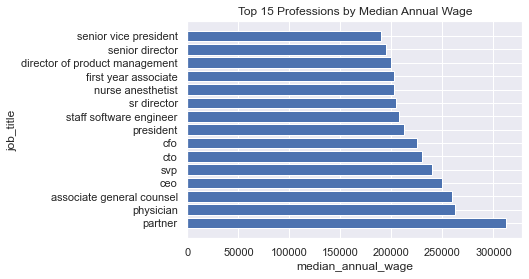

In [62]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'job_title',
    agg_col = 'annual_wage',
    title = 'Top 15 Professions by Median Annual Wage',
    th = 5,
    n = 15
)

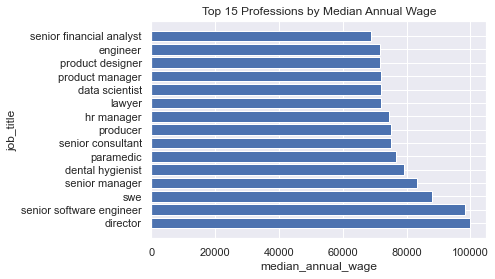

In [63]:
visualize_group(
    d = ca_df,
    remove_vals = None, 
    group_col = 'job_title',
    agg_col = 'annual_wage',
    title = 'Top 15 Professions by Median Annual Wage',
    th = 5,
    n = 15
)

## Industries with the Highest Median Salary

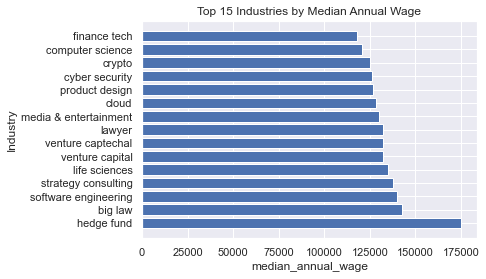

In [64]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'Industry',
    agg_col = 'annual_wage',
    title = 'Top 15 Industries by Median Annual Wage',
    th = 5,
    n = 15
)

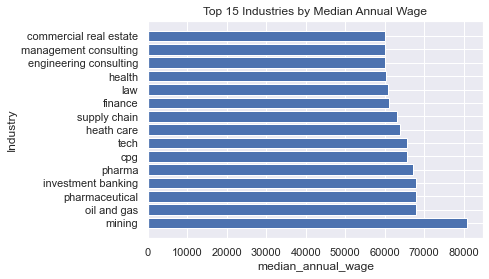

In [65]:
visualize_group(
    d = ca_df,
    remove_vals = None, 
    group_col = 'Industry',
    agg_col = 'annual_wage',
    title = 'Top 15 Industries by Median Annual Wage',
    th = 5,
    n = 15
)

## Average Income per YoE

In [66]:
yoe_df = d.copy()
yoe_df['yoe'] = yoe_df['yoe'].apply(lambda x : [20 if x == '20+' else x][0]).astype(float)

In [67]:
# visualize_group(
#     d = yoe_df,
#     remove_vals = None, 
#     group_col = 'yoe',
#     agg_col = 'annual_wage',
#     title = 'Median YoE per Year of Experience',
#     th = 5,
#     n = 20
# )

## Median Wages per Gender

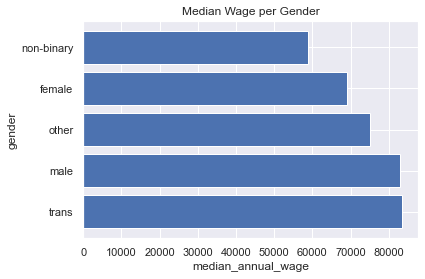

In [68]:
visualize_group(
    d = yoe_df,
    remove_vals = None, 
    group_col = 'gender',
    agg_col = 'annual_wage',
    title = 'Median Wage per Gender',
    th = 5,
    n = 20
)

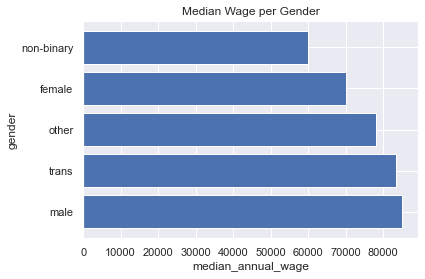

In [69]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'gender',
    agg_col = 'annual_wage',
    title = 'Median Wage per Gender',
    th = 5,
    n = 20
)

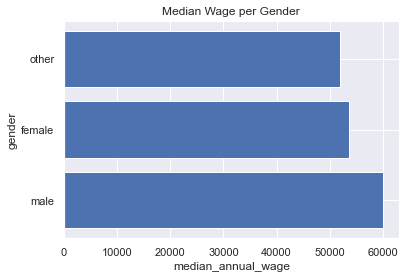

In [70]:
visualize_group(
    d = ca_df,
    remove_vals = None, 
    group_col = 'gender',
    agg_col = 'annual_wage',
    title = 'Median Wage per Gender',
    th = 5,
    n = 20
)

## Median Wages per Ethnic Group  

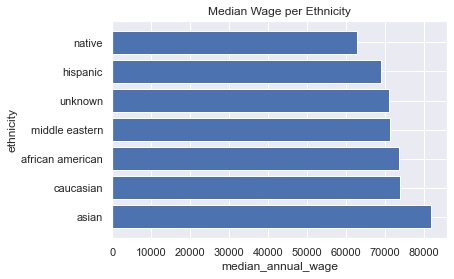

In [71]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'ethnicity',
    agg_col = 'annual_wage',
    title = 'Median Wage per Ethnicity',
    th = 5,
    n = 20
)

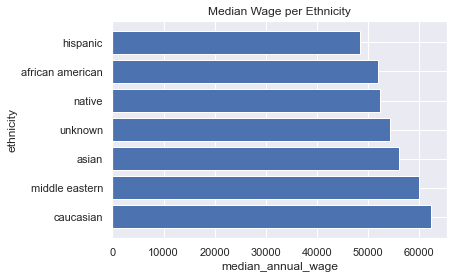

In [72]:
visualize_group(
    d = ca_df,
    remove_vals = None, 
    group_col = 'ethnicity',
    agg_col = 'annual_wage',
    title = 'Median Wage per Ethnicity',
    th = 5,
    n = 20
)

## Median Wages per Age Group

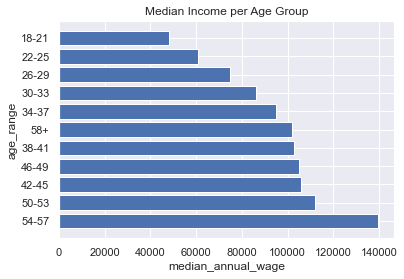

In [73]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'age_range',
    agg_col = 'annual_wage',
    title = 'Median Income per Age Group',
    th = 5,
    n = None
)

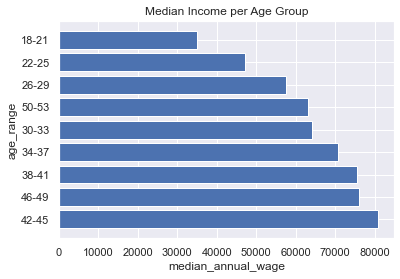

In [74]:
visualize_group(
    d = ca_df,
    remove_vals = None, 
    group_col = 'age_range',
    agg_col = 'annual_wage',
    title = 'Median Income per Age Group',
    th = 5,
    n = None
)

## Highest Paying Organizations

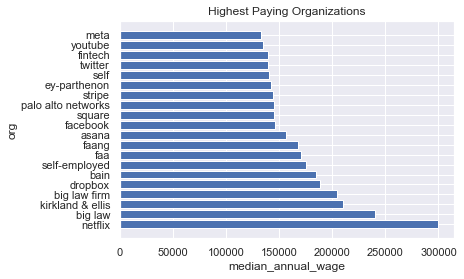

In [75]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'org',
    agg_col = 'annual_wage',
    title = 'Highest Paying Organizations',
    th = 5,
    n = 20
)

## Median Wages per Maximum Education Level

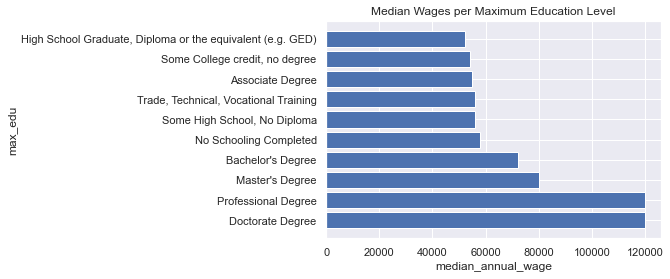

In [76]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'max_edu',
    agg_col = 'annual_wage',
    title = 'Median Wages per Maximum Education Level',
    th = 5,
    n = None
)

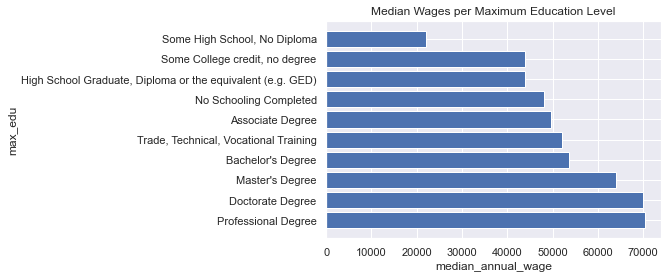

In [79]:
visualize_group(
    d = ca_df,
    remove_vals = None, 
    group_col = 'max_edu',
    agg_col = 'annual_wage',
    title = 'Median Wages per Maximum Education Level',
    th = 5,
    n = None
)

## Highest Paying Locations

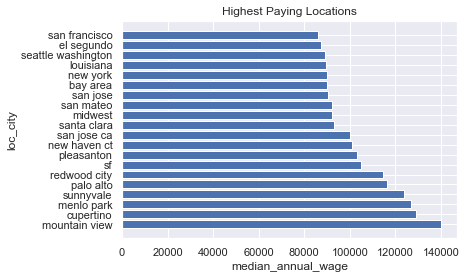

In [77]:
visualize_group(
    d = d[d['country'] == 'usa'],
    remove_vals = None, 
    group_col = 'loc_city',
    agg_col = 'annual_wage',
    title = 'Highest Paying Locations',
    th = 5,
    n = 20
)

## Caveats
Please be aware that there are a lot of things to consider when analyzing and conducting this analysis. A saying in data science is that the quality of your results is purely dependent on the quality of the data. With that beings said, since the data in this article was provided anonymously from random people through LinkedIn, a lot of the results is based on the integrity of each individual who provided information. Furthermore, the data could definitely be cleaned a lot more rigorously. For the purposes of this article I aimed to clean **majority** of the data but not all, with that being said, the results observed above could definitely be different if further cleaning was done. Finally, different datasets trying to answer the same questions can come to different conclusions, if Glassdoor or Indeed were to do this exact same analysis to answer the same questions, I would be skeptical to see that they get the same sort of results / conclusions.

## Concluding Remarks
Overall the analysis conducted was interesting but with this dataset a lot more interesting things and questions could be answers. I created a generalized function which would answer a variety of questions I proposed for this article simply out of curiosity. The data is publicly available and more individuals could contribute to it even after the posting of this article. With that being said, feel free to ask your own questions, and spark your own curiosity. For individuals wanting to break into a data driven role, being curious, taking initiative, communicating results and thinking critically are essential to be successful in any data driven roles. Continue the work on this by answering unanswered questions.

In [42]:
d2= d.copy()
d2['is_ds'] = d2['job_title'].apply(lambda x : [True if str(x).lower() in ['data', 'science', 'data science', 'data scientist', 'research'] else False][0])

In [43]:
d2[d2['is_ds']==True].annual_wage.max()

209000.0

In [46]:
d2[(d2['is_ds'] == True) & (d2['annual_wage'] >= 200000) ]

,timestamp,age_range,yoe,Industry,job_title,org,max_edu,loc_city,country,annual_wage,...,signing_bonus,currency,vacation_days_yearly,sick_days_yearly,days_per_week_in_office,open_wage_discussions,maternity_leave_months,gender,ethnicity,is_ds
9879,12/7/2021 2:37:40,26-29,4,data science,data scientist,ibm,Master's Degree,sf,usa,209000.0,...,13000.0,usd,19,unlim,"None, I work fully remote",yes,6,male,unknown,True
10533,12/7/2021 10:10:58,38-41,20+,defense gov contractor,data scientist,"prefer not to say, but one of the big 5 defens...",Doctorate Degree,rochester,usa,200000.0,...,10000.0,usd,20,0,5,other,unknown,male,unknown,True
54703,12/20/2021 18:15:35,26-29,6,hedge fund,data scientist,two sigma,Bachelor's Degree,nyc,usa,205000.0,...,50000.0,usd,23,unlim,5,no,3,female,unknown,True


In [1]:
import pandas as pd
import requests
import numpy as np

In [2]:
levels_fyi_data = requests.get('https://www.levels.fyi/js/salaryData.json').json()
levels_df = pd.DataFrame(levels_fyi_data)
levels_df.shape

(62642, 17)

In [3]:
levels_df = levels_df.drop(['cityid', 'dmaid','rowNumber'], axis=1)
levels_df = levels_df.replace("", np.nan)

In [4]:
levels_df['timestamp'] = pd.to_datetime(levels_df['timestamp'])
levels_df[
    ['yearsofexperience','basesalary','bonus','stockgrantvalue','totalyearlycompensation','yearsatcompany']
] = levels_df[
    ['yearsofexperience','basesalary','bonus','stockgrantvalue','totalyearlycompensation','yearsatcompany']
].apply(pd.to_numeric)

In [5]:
levels_df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,NaN,107.0,20.0,10.0,NaN,NaN
1,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,100.0,"San Francisco, CA",5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,NaN,155.0,NaN,NaN,NaN,NaN
3,2017-06-14 21:22:25,Microsoft,64,Software Engineering Manager,200.0,"Redmond, WA",9.0,9.0,NaN,169000.0,100000.0,30000.0,NaN,NaN
4,2017-06-16 10:44:01,Amazon,L5,Software Engineer,173.0,"Vancouver, BC, Canada",11.0,1.0,NaN,120000.0,0.0,53000.0,NaN,NaN


In [6]:
levels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timestamp                62642 non-null  datetime64[ns]
 1   company                  62642 non-null  object        
 2   level                    62642 non-null  object        
 3   title                    62642 non-null  object        
 4   totalyearlycompensation  62642 non-null  float64       
 5   location                 62642 non-null  object        
 6   yearsofexperience        62642 non-null  float64       
 7   yearsatcompany           62642 non-null  float64       
 8   tag                      61856 non-null  object        
 9   basesalary               60338 non-null  float64       
 10  stockgrantvalue          59958 non-null  float64       
 11  bonus                    58654 non-null  float64       
 12  gender                   43102 n

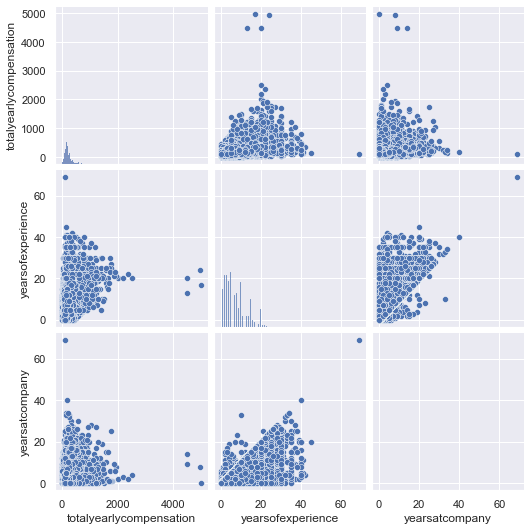

In [12]:
sns.pairplot(levels_df[[
    'totalyearlycompensation', 'yearsofexperience', 'yearsatcompany'
]])